In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
from scipy.interpolate import splprep, splev

### Init global variables

In [2]:
circuits = [
    "Monaco", "Miami", "Saudi_Arabia", "Japan", 
    "Bahrain", "Spain", "Canada", #"Australia", 
    "Emilia_Romagna", "Las_Vegas"
]

race_tracks = [
    "Monaco", "Miami", "Jeddah", "Suzuka",
    "Sakhir", "Barcelona", "Montreal", #"Melbourne",
    "Imola", "Las Vegas"
]

driver_id = "VER"

### Race track function definitions

In [3]:
def latlon_to_xy(lat, lon, origin_lat=0, origin_lon=0):

    # WGS84 ellipsoid constants
    EARTH_RADIUS = 6378137.0  # Earth's radius in meters
    
    def deg_to_rad(degrees):
        return degrees * (np.pi / 180.0)
    
    # Convert to radians
    lat_rad = deg_to_rad(lat)
    lon_rad = deg_to_rad(lon)
    origin_lat_rad = deg_to_rad(origin_lat)
    origin_lon_rad = deg_to_rad(origin_lon)
    
    # Mercator projection
    x = EARTH_RADIUS * (lon_rad - origin_lon_rad)
    y = EARTH_RADIUS * np.log(
        np.tan(np.pi/4 + lat_rad/2) / 
        np.tan(np.pi/4 + origin_lat_rad/2)
    )
    
    return pd.Series([x, y])

In [4]:
def smooth_track_data(x, y, num_points=1000):

    # Remove duplicate consecutive points
    points = np.column_stack((x, y))
    unique_points = np.vstack([tuple(row) for row in points])
    x, y = unique_points.T
    
    # Fit a B-spline
    tck, u = splprep([x, y], s=0, k=1, per=True)
    
    # Generate points along the smoothed curve
    u_new = np.linspace(0, 1, num_points)
    x_new, y_new = splev(u_new, tck)
    
    return x_new, y_new

In [5]:
def calculate_curvature(x, y):

    # Ensure inputs are numpy arrays
    x = np.array(x)
    y = np.array(y)
    
    # Calculate first derivatives
    dx_dt = np.gradient(x)
    dy_dt = np.gradient(y)
    
    # Calculate second derivatives
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    
    # Calculate curvature using kappa coefficient formula
    curvature = np.abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2)**(3/2)
    
    return curvature

In [6]:
def plot_track_curvature(x, y, curvature, track_name):

    plt.figure(figsize=(15, 10))
    
    # Plot track colored by curvature
    points = plt.scatter(x, y, c=curvature, cmap='viridis', 
                        s=10, 
                        label=f'Maximum Curvature: {np.max(curvature):.4f}\nAverage Curvature: {np.mean(curvature):.4f}'
            )
    plt.colorbar(points, label='Curvature (1/m)')
    plt.legend()
    plt.title(f'{track_name} Track Curvature Analysis')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

In [7]:
# Read data from geojson file
file = open("./datasets/f1-circuits.geojson", "rb")
content = file.read()
tracks_data = json.loads(content)["features"]

def load_track_data(track_name):
    # Select track coordinates
    select_gp = [x["geometry"]["coordinates"] for x in tracks_data if x["properties"]["Location"] == track_name]
    track_data = pd.DataFrame(select_gp[0], columns=["lon", "lat"])

    # Convert latlon track coordinates to xy coordinates
    track_data[["x", "y"]] = track_data.apply(
        lambda row: latlon_to_xy(row["lat"], row["lon"]), axis=1
    )

    return track_data


### F1 race data function definitions

In [8]:
def merge_lap_telemetry_data(select_lap_data: pd.DataFrame, driver_telemetry: pd.DataFrame):
    additional_columns = []#["TrackStatus", "Compound"]

    lap_times = select_lap_data.index
    lap_numbers = select_lap_data['LapNumber']

    # Initialize lap column
    result_df = driver_telemetry.copy()
    result_df['LapNumber'] = None

    # Assign lap numbers
    for i in range(len(lap_times)-1):
        current_lap_start = lap_times[i]
        next_lap_start = lap_times[i+1]
        current_lap_number = lap_numbers.iloc[i]
        
        # Assign lap number to all rows between current and next lap start
        mask = (result_df.index >= current_lap_start) & (result_df.index < next_lap_start)
        result_df.loc[mask, 'LapNumber'] = current_lap_number

        for col in additional_columns:
            result_df.loc[mask, col] = select_lap_data[col].iloc[i]

    # Handle last lap
    last_lap_mask = result_df.index >= lap_times[-1]
    result_df.loc[last_lap_mask, 'LapNumber'] = lap_numbers.iloc[-1]

    # Handle additional columns for last lap
    for col in additional_columns:
        result_df.loc[last_lap_mask, col] = select_lap_data[col].iloc[-1]

    driver_telemetry = result_df.copy()

    return driver_telemetry

In [9]:
def calculate_vel_accel_by_lap(driver_telemetry: pd.DataFrame):

    car_data = pd.DataFrame(
        {
            "Speed": driver_telemetry["Speed"].values / 3.6, # convert from km/h to m/s
            "LapNumber": driver_telemetry["LapNumber"].values
        },
        index = driver_telemetry.index
    )

    # Resample and aggregate selected data
    downsampled_groups = []
    for lap, by_lap_data in car_data.groupby('LapNumber'):
        lap_downsampled = by_lap_data.resample('1S').agg({
            'Speed': 'mean',
            'LapNumber': 'first'
        })
        
        downsampled_groups.append(lap_downsampled)

    resampled_car_data = pd.concat(downsampled_groups).sort_index()

    # Calculate car acceleration
    acceleration = np.abs(np.gradient(resampled_car_data["Speed"].values))
    resampled_car_data["Acceleration"] = acceleration

    car_data_by_lap = resampled_car_data.groupby("LapNumber").mean()

    return car_data_by_lap


In [10]:
def calculate_engine_force_by_lap(acceleration_by_lap):
    m_car = 798
    m_fuel = 110
    mu = 1.7
    
    n_laps = len(acceleration_by_lap)
    m_total = m_car + m_fuel
    fuel_consumption = m_fuel / n_laps # Linear fuel consuption by each lap

    engine_force_data = []
    for accel in acceleration_by_lap:
        engine_force_data.append((m_total * accel) / mu)
        m_fuel -= fuel_consumption
        m_total = m_car + m_fuel

    return engine_force_data

In [41]:
def plot_race_comparison(force_dict, curvature_dict):
    
    # Create figure and axis objects with a single subplot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[1, 1])
    #fig.suptitle('Race Data Comparison', fontsize=16, y=1.0)
    
    # Get x-axis positions for the bars
    races = list(force_dict.keys())
    x_pos = np.arange(len(races))
    
    # Plot engine force data
    force_bars = ax1.bar(x_pos, list(force_dict.values()), color='skyblue')
    ax1.set_ylabel('Mean Engine Force')
    ax1.set_title('Engine Force by Race')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(races, rotation=45, ha='right')
    
    # Add value labels on top of each bar
    for bar in force_bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')
        
    # Add padding to y-axis limits
    force_max = max(force_dict.values())
    ax1.set_ylim(0, force_max * 1.1)  # Add 10% padding to top
    
    # Plot curvature coefficient data
    curve_bars = ax2.bar(x_pos, list(curvature_dict.values()), color='lightgreen')
    ax2.set_ylabel('Curvature Coefficient')
    ax2.set_title('Curvature Coefficient by Race')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(races, rotation=45, ha='right')
    
    # Add value labels on top of each bar
    for bar in curve_bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom')
    
    # Add padding to y-axis limits
    curve_max = max(curvature_dict.values())
    ax2.set_ylim(0, curve_max * 1.1)  # Add 10% padding to top
    
    # Adjust layout to prevent overlapping
    plt.tight_layout(h_pad=3.0)
    
    return fig, (ax1, ax2)

### Main

In [13]:
races_mean_engine_force = {}
track_curvature_values = {}

for circuit_name, track_name in zip(circuits, race_tracks):

    # Load data
    lap_data = pd.read_csv(f"./datasets/lapdata/{circuit_name}_Grand_Prix.csv")
    telem_data = pd.read_csv(f"./datasets/telemetry_data/{circuit_name}_time_series.csv")

    # Preprocess lap data
    driver_laps = lap_data.loc[lap_data["Driver"] == driver_id]
    driver_laps = driver_laps.set_index(
        pd.to_datetime(driver_laps["LapStartDate"])).drop(["LapStartDate"], axis=1
    )
    select_lap_data = driver_laps[["LapNumber", "TrackStatus", "Compound", "TyreLife"]]

    # Preprocess telemetry data
    driver_telemetry = telem_data.loc[telem_data["Driver"] == driver_id] \
        [["Date", "RPM", "Speed", "nGear", "Throttle"]]
    driver_telemetry = driver_telemetry \
            .set_index(pd.to_datetime(driver_telemetry["Date"])).drop(["Date"], axis=1)
    
    # Merge lap data with telemetry data
    driver_telemetry = merge_lap_telemetry_data(select_lap_data, driver_telemetry)

    # Calculate car velocity and acceleration by lap
    car_data_by_lap = calculate_vel_accel_by_lap(driver_telemetry)

    # Calculate mean car engine force by lap
    car_data_by_lap["EngineForce"] = calculate_engine_force_by_lap(car_data_by_lap["Acceleration"].values)
    
    races_mean_engine_force.update(
        {circuit_name: np.mean(car_data_by_lap["EngineForce"].values)}
    )

    # Calculate kappa curvature coefficient
    track_data = load_track_data(track_name)
    x_smooth, y_smooth = smooth_track_data(track_data["x"].values, track_data["y"].values)
    curvature = calculate_curvature(x_smooth, y_smooth)

    track_curvature_values.update(
        {circuit_name: np.mean(curvature)}
    )



{'Monaco': 3001.192495540089, 'Miami': 2685.965963054874, 'Saudi_Arabia': 2573.292557236053, 'Japan': 2422.4231875627956, 'Bahrain': 3241.5725875518456, 'Spain': 2712.7562466633026, 'Canada': 3162.833022905901, 'Emilia_Romagna': 3041.5912272853625, 'Las_Vegas': 2938.91436669197}
{'Monaco': 0.007954912652801384, 'Miami': 0.0048828596381323254, 'Saudi_Arabia': 0.004449061226124286, 'Japan': 0.00421048730417526, 'Bahrain': 0.004009841382881071, 'Spain': 0.004041891105635629, 'Canada': 0.0035382814779035825, 'Emilia_Romagna': 0.002875592651084668, 'Las_Vegas': 0.0028216009225594395}


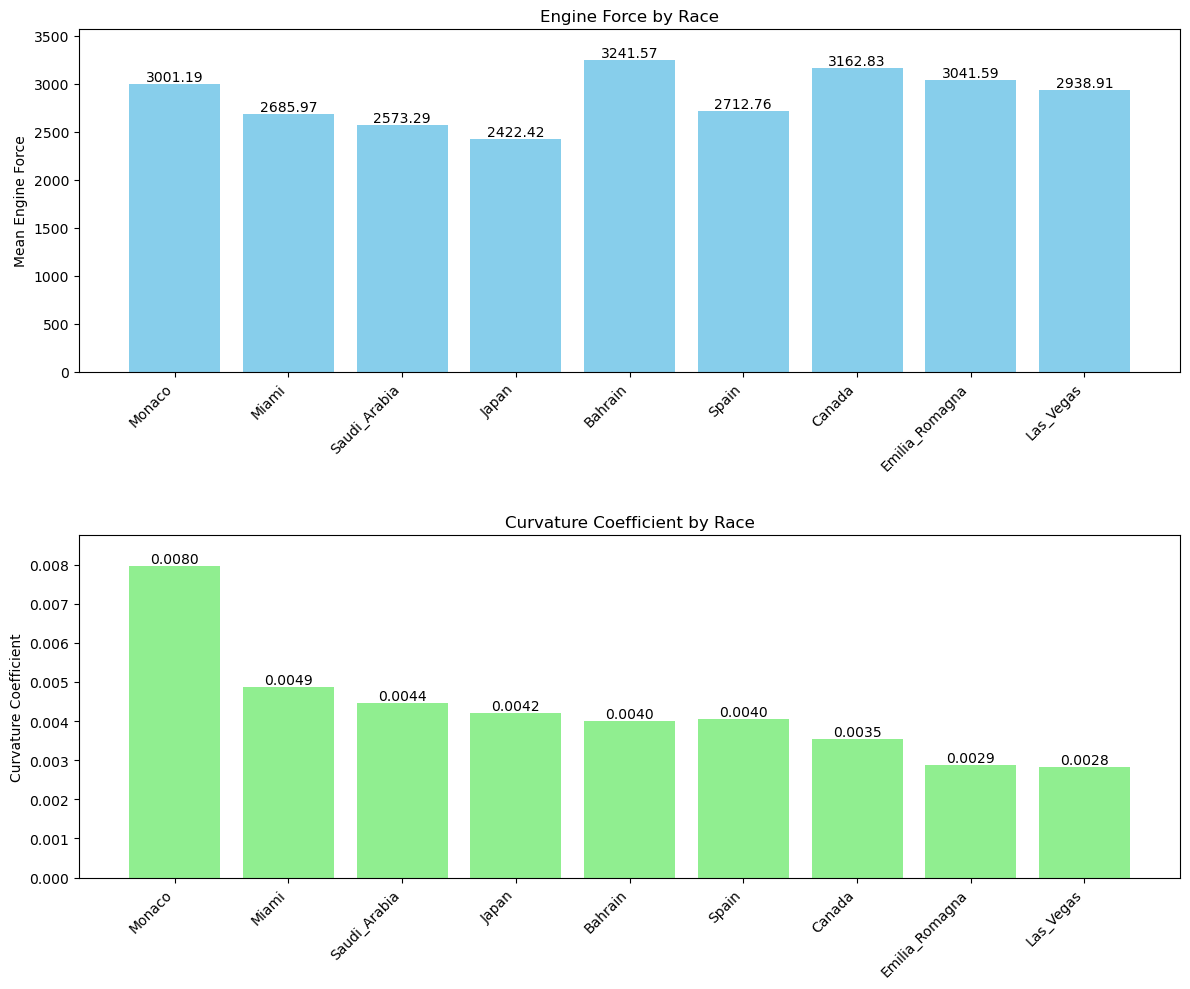

In [42]:
print(races_mean_engine_force)
print(track_curvature_values)

fig, axes = plot_race_comparison(races_mean_engine_force, track_curvature_values)
